<a href="https://colab.research.google.com/github/mindaugo1/acv/blob/master/ACV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
Setup = False
DOWNLOAD_DATA = False

In [0]:
import os

try:
    %tensorflow_version 2.x    
    %matplotlib inline
except:
    %load_ext lab_black
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
if Setup:
  !pip install -q -U toai tensorflow-datasets tensorflow_hub 
  !pip install -q -U --no-deps tensorflow-addons~=0.6

In [44]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.4.1
2.1.0


In [0]:
from toai.imports import *
from toai.image import ImageAugmentor, ImageParser, ImageResizer, ImageDataContainer
from toai.data.utils import split_df
from toai.encode import CategoricalEncoder
from typing import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from matplotlib.patches import Rectangle
from imageio import imread
from skimage.transform import resize
from glob import glob


#Loading data

In [0]:
DATA_DIR = Path("data/guns")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/guns")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
if DOWNLOAD_DATA:
    !rm - rf data
    !rm - fr temp
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir .kaggle/
    !cp ./drive/My\ Drive/'Colab Notebooks'/kaggle/kaggle.json /root/.kaggle/
    !chmod 600 / root/.kaggle/kaggle.json
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    TEMP_DIR.mkdir(parents=True, exist_ok=True)
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('issaisasank/guns-object-detection', path=DATA_DIR, unzip=True)


In [0]:
import os

In [0]:
def make_df_from_dir():
    data = {
        'filename': [],
        'path': [],
        'number_of_guns': [],
        'x0': [],
        'y0': [],
        'x1': [],
        'y1': [],
    }  
    for item in os.listdir(f'{DATA_DIR}/Images'):
        data['filename'].append(item[:-5])
        data['path'].append(f"{DATA_DIR}/Images/{item}")
        with open(f'{DATA_DIR}/Labels/{item[:-5]}.txt', 'r') as f:
          file_content = f.read()
          splitted_content = file_content.split('\n')
          number_of_guns = splitted_content[0]
          data['number_of_guns'].append(number_of_guns)
          box_coordinates = splitted_content[1].split(' ')
          data['x0'].append(box_coordinates[0])
          data['y0'].append(box_coordinates[1])
          data['x1'].append(box_coordinates[2])
          data['y1'].append(box_coordinates[3])
            
    return pd.DataFrame(data)

In [0]:
data = make_df_from_dir()

In [0]:
data = data.astype({'number_of_guns': 'int32', 'x0': 'int32', 'y0': 'int32', 'x1': 'int32', 'y1': 'int32'})
data = pd.DataFrame(data, columns=['filename', 'number_of_guns', 'x0', 'y0', 'x1', 'y1', 'path'])

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
filename          333 non-null object
number_of_guns    333 non-null int32
x0                333 non-null int32
y0                333 non-null int32
x1                333 non-null int32
y1                333 non-null int32
path              333 non-null object
dtypes: int32(5), object(2)
memory usage: 11.8+ KB


In [53]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_guns,333.0,1.285285,0.940869,1.0,1.0,1.0,1.0,12.0
x0,333.0,99.048048,55.533048,3.0,56.0,99.0,136.0,232.0
y0,333.0,55.582583,30.213347,4.0,33.0,53.0,73.0,154.0
x1,333.0,186.942943,61.495663,35.0,140.0,186.0,234.0,346.0
y1,333.0,116.084084,37.421872,25.0,88.0,111.0,142.0,230.0


In [54]:
data['number_of_guns'].unique()

array([ 1,  4, 11,  2,  3, 12])

In [55]:
data.loc[data['number_of_guns'] == 11]

,filename,number_of_guns,x0,y0,x1,y1,path
21,99,11,204,150,265,182,data/guns/Images/99.jpeg


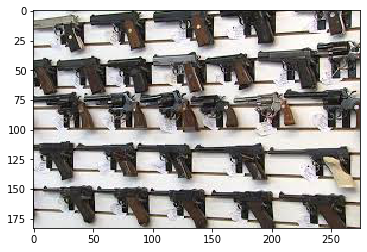

In [56]:
img = keras.preprocessing.image.load_img(data.loc[data['number_of_guns'] == 11]['path'].values[0])
plt.imshow(img)
plt.show()

In [0]:
drop_rows = data.loc[data['number_of_guns'] >1].index
data.drop(drop_rows, inplace=True)
data.reset_index(inplace=True)

In [58]:
data.loc[data['number_of_guns'] >1]

,index,filename,number_of_guns,x0,y0,x1,y1,path


In [59]:
data.head()

,index,filename,number_of_guns,x0,y0,x1,y1,path
0,0,157,1,100,33,177,124,data/guns/Images/157.jpeg
1,1,120,1,16,50,80,108,data/guns/Images/120.jpeg
2,2,222,1,10,11,152,120,data/guns/Images/222.jpeg
3,3,221,1,92,71,141,200,data/guns/Images/221.jpeg
4,4,199,1,167,32,218,93,data/guns/Images/199.jpeg


In [0]:
def get_image_dims(arr):
    heights, widths = [], []
    for filename in progress_bar(arr):
        height, width, _ = np.array(keras.preprocessing.image.load_img(filename)).shape
        heights.append(height)
        widths.append(width)
    return np.asarray(heights), np.asarray(widths)

In [61]:
data[["height", "width"]] = pd.DataFrame(get_image_dims(data["path"])).T

In [62]:
data.head()

,index,filename,number_of_guns,x0,y0,x1,y1,path,height,width
0,0,157,1,100,33,177,124,data/guns/Images/157.jpeg,194,260
1,1,120,1,16,50,80,108,data/guns/Images/120.jpeg,193,262
2,2,222,1,10,11,152,120,data/guns/Images/222.jpeg,186,271
3,3,221,1,92,71,141,200,data/guns/Images/221.jpeg,249,202
4,4,199,1,167,32,218,93,data/guns/Images/199.jpeg,148,341


In [0]:
data["x0"] = data["x0"] / data["width"]
data["x1"] = data["x1"] / data["width"]
data["y0"] = data["y0"] / data["height"]
data["y1"] = data["y1"] / data["height"]

In [0]:
data["object_width"] = data["x1"] - data["x0"]
data["object_height"] = data["y1"] - data["y0"]

In [65]:
data.head()

,index,filename,number_of_guns,x0,y0,x1,y1,path,height,width,object_width,object_height
0,0,157,1,0.384615,0.170103,0.680769,0.639175,data/guns/Images/157.jpeg,194,260,0.296154,0.469072
1,1,120,1,0.061069,0.259067,0.305344,0.559585,data/guns/Images/120.jpeg,193,262,0.244275,0.300518
2,2,222,1,0.036900,0.059140,0.560886,0.645161,data/guns/Images/222.jpeg,186,271,0.523985,0.586022
3,3,221,1,0.455446,0.285141,0.698020,0.803213,data/guns/Images/221.jpeg,249,202,0.242574,0.518072
4,4,199,1,0.489736,0.216216,0.639296,0.628378,data/guns/Images/199.jpeg,148,341,0.149560,0.412162


#Preparing dataset

In [0]:
BATCH_SIZE = 12
SHUFFLE_SIZE = 40
IMG_DIMS = (224, 224, 3)
N_IMAGES = data.shape[0]

In [0]:
#code form toai library
def split_df(data, test_size, target_col: str = None, random_state: int = 42):
    stratify = data[target_col] if target_col else None
    train_data, test_data = train_test_split(
        data, test_size=test_size, stratify=stratify, random_state=random_state
    )
    test_stratify = test_data[target_col] if target_col else None
    val_data, test_data = train_test_split(
        test_data, test_size=0.5, stratify=test_stratify, random_state=random_state
    )
    for df in train_data, val_data, test_data:
        df.reset_index(drop=True, inplace=True)
    return train_data, val_data, test_data

In [0]:
train_data, validation_data, test_data = split_df(data, 0.2)

In [0]:
train_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            train_data["path"],
            tuple(
                [
                    train_data[["x0", "y0", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .map(ImageAugmentor(level=3, rotate=False))
    .repeat()
    .shuffle(SHUFFLE_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
validation_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            validation_data["path"],
            tuple(
                [
                    validation_data[["x0", "y0", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
test_set = (
    tf.data.Dataset.from_tensor_slices(
        (
            test_data["path"],
            tuple(
                [
                    test_data[["x0", "y0", "object_width", "object_height"]].values,
                ]
            ),
        )
    )
    .map(ImageParser())
    .map(ImageResizer(IMG_DIMS, "stretch"))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [0]:
def make_rectangle(x0, y0, width, height, img_dims, color, linewidth=2):
    return Rectangle(
        (x0 * img_dims[1], y0 * img_dims[0]),
        width * img_dims[1],
        height * img_dims[0],
        linewidth=linewidth,
        edgecolor=color,
        facecolor="none",
    )

In [0]:
%matplotlib inline

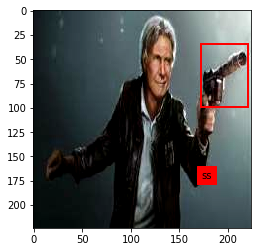

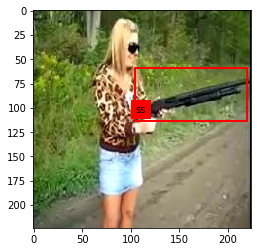

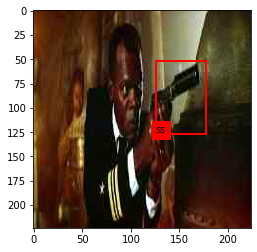

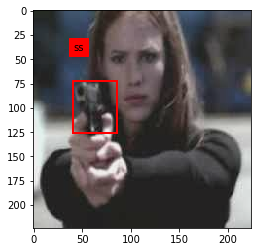

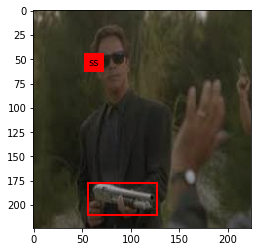

In [74]:
for x, y in train_set.take(5):
    n_image = 0
    bounding_boxes = y
    bounding_box = bounding_boxes[n_image][0].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(x[n_image].numpy())
    plt.text(
        bounding_box[0] * IMG_DIMS[0],
        bounding_box[0] * IMG_DIMS[1],
        'ss',
        backgroundcolor="red",
    )
    y_rect = make_rectangle(*bounding_box, IMG_DIMS, "r")
    ax.add_patch(y_rect)
    plt.show()

In [0]:
class GlobalConcatPooling2D(keras.layers.Layer):
    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        return keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(layer),
                keras.layers.GlobalMaxPool2D()(layer),
            ]
        )

In [0]:
def make_model():
    base = keras.applications.Xception(
        input_shape=IMG_DIMS, include_top=False, weights="imagenet"
    )
    x = GlobalConcatPooling2D()(base.output)
    x = keras.layers.Dropout(0.4)(x)
    keras.layers.Dense(4, activation=keras.activations.sigmoid)(x)

    bounding_box = keras.layers.Dense(4, activation=keras.activations.sigmoid)(x)
    model = keras.Model(inputs=base.input, outputs=[bounding_box])
    model.compile(
        loss=[

            keras.losses.BinaryCrossentropy(),
        ],

        optimizer=keras.optimizers.Adam(1e-4),
    )
    return model

In [0]:

model = make_model()

In [78]:
model.fit(
    x=train_set,
    validation_data=validation_set,
    steps_per_epoch=math.ceil(train_data.shape[0] / BATCH_SIZE),
    epochs=21,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            str(TEMP_DIR / "model.h5"), save_best_only=True, save_weights_only=True
        ),
        keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=2),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
)

Train for 18 steps, validate for 3 steps
Epoch 1/21
18/18 [==============================] - 8s 464ms/step - loss: 0.6871 - val_loss: 0.7091
Epoch 2/21
18/18 [==============================] - 4s 195ms/step - loss: 0.6242 - val_loss: 0.6882
Epoch 3/21
18/18 [==============================] - 3s 193ms/step - loss: 0.6142 - val_loss: 0.6479
Epoch 4/21
18/18 [==============================] - 4s 195ms/step - loss: 0.6002 - val_loss: 0.6311
Epoch 5/21
18/18 [==============================] - 3s 192ms/step - loss: 0.5989 - val_loss: 0.6228
Epoch 6/21
18/18 [==============================] - 3s 192ms/step - loss: 0.5902 - val_loss: 0.6197
Epoch 7/21
18/18 [==============================] - 4s 196ms/step - loss: 0.5923 - val_loss: 0.6180
Epoch 8/21
18/18 [==============================] - 3s 193ms/step - loss: 0.5845 - val_loss: 0.6128
Epoch 9/21
18/18 [==============================] - 3s 172ms/step - loss: 0.5847 - val_loss: 0.6133
Epoch 10/21
18/18 [==============================] - 3s 191

In [0]:
def predict(model, dataset, n_image=0):
    for x, y in dataset.take(1):
        fig, ax = plt.subplots(1)
        ax.imshow(x[n_image].numpy())

        p_bounding_boxes = model.predict(x)
        p_bounding_box = p_bounding_boxes[n_image]
        plt.text(
            (p_bounding_box[0] + p_bounding_box[2]) * IMG_DIMS[0] - 25,
            p_bounding_box[1] * IMG_DIMS[1],
            'Predicted',
            color="white",
            backgroundcolor="blue",
            fontsize=16,
        )
        p_rect = make_rectangle(*p_bounding_box, IMG_DIMS, "b", 3)
        ax.add_patch(p_rect)



        y_bounding_boxes = y
        y_bounding_box = y_bounding_boxes[0][n_image].numpy()

        plt.text(
            y_bounding_box[0] * IMG_DIMS[0] + 5,
            y_bounding_box[1] * IMG_DIMS[1],
            'Actual',
            backgroundcolor="red",
            fontsize=16,
        )
        y_rect = make_rectangle(*y_bounding_box, IMG_DIMS, "r")
        ax.add_patch(y_rect)

        plt.show()

#Show predictions

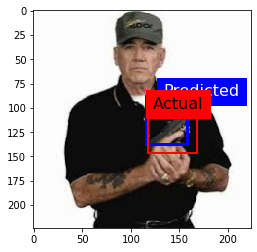

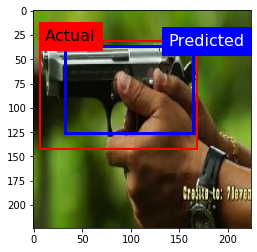

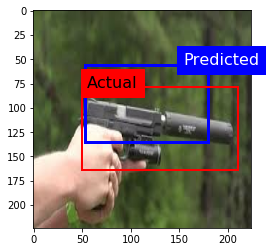

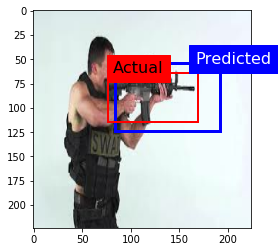

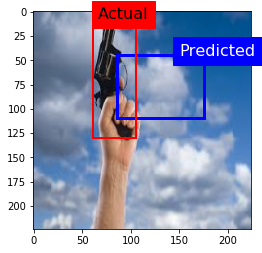

In [102]:
for i in range(5):
  predict(model, validation_set, n_image=i)